In [121]:
import pickle 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

import xgboost as xgb
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split

from hyperopt import hp, fmin, tpe, Trials

import io
import os
from PIL import Image

import json

In [122]:
df = pd.read_csv('../../data/day_ahead_energy_prices.csv', delimiter=",")[::-1]
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

df.rename(columns={"hourly day-ahead energy price": "Price"}, inplace=True)
df

,Price
Datetime,
2024-11-21 23:00:00,107.46
2024-11-21 22:00:00,122.90
2024-11-21 21:00:00,123.05
2024-11-21 20:00:00,131.33
2024-11-21 19:00:00,154.05
...,...
2018-10-01 04:00:00,47.59
2018-10-01 03:00:00,47.38
2018-10-01 02:00:00,51.41


In [123]:
mix_df = pd.read_csv('../../data/hourly_market_mix_cleaned.csv', delimiter=",")[::-1]
mix_df.set_index("Timestamp", inplace=True)
mix_df.index = pd.to_datetime(mix_df.index)
mix_df.rename_axis("Datetime", inplace=True) 
mix_df = mix_df.loc[:, mix_df.max() >= 0.01]
mix_df


,Biomass,Hard Coal,Hydro,Lignite,Natural Gas,Nuclear,Other,Pumped storage generation,Solar,Wind offshore,Wind onshore
Datetime,,,,,,,,,,,
2024-10-30 00:00:00,0.101101,0.145455,0.045090,0.260219,0.243971,0.000000,0.049146,0.000022,0.0,0.047519,0.107476
2024-10-29 23:00:00,0.097725,0.149445,0.044872,0.274110,0.243789,0.000000,0.046156,0.000599,0.0,0.040935,0.102369
2024-10-29 22:00:00,0.095872,0.150584,0.047273,0.270704,0.255679,0.000000,0.046154,0.001140,0.0,0.035149,0.097447
2024-10-29 21:00:00,0.095560,0.150384,0.044436,0.265195,0.268427,0.000000,0.046835,0.002805,0.0,0.030024,0.096333
2024-10-29 20:00:00,0.093081,0.142999,0.047220,0.253702,0.278486,0.000000,0.044794,0.014459,0.0,0.027928,0.097331
...,...,...,...,...,...,...,...,...,...,...,...
2018-10-01 04:00:00,0.092527,0.148990,0.019701,0.282126,0.146368,0.138012,0.040888,0.003391,0.0,0.045451,0.082545
2018-10-01 03:00:00,0.093932,0.146157,0.020071,0.286085,0.153114,0.140053,0.041441,0.003452,0.0,0.039751,0.075943
2018-10-01 02:00:00,0.094656,0.139489,0.020001,0.286402,0.161350,0.142441,0.041791,0.003471,0.0,0.038929,0.071471


In [124]:
weather_forecast_df = pd.read_csv("../../data/weather_forcast_prediciton.csv")[::-1]
weather_forecast_df.set_index("date" ,inplace=True)
weather_forecast_df.index = pd.to_datetime(weather_forecast_df.index)
weather_forecast_df.index = weather_forecast_df.index.tz_localize(None)
weather_forecast_df.rename_axis("Datetime",inplace=True)
weather_forecast_df.index = weather_forecast_df.index - pd.Timedelta(hours=24)

weather_forecast_df

,temperature_2m,temperature_2m_previous_day1,temperature_2m_previous_day2,temperature_2m_previous_day3,temperature_2m_previous_day4,temperature_2m_previous_day5,temperature_2m_previous_day6,temperature_2m_previous_day7,relative_humidity_2m,relative_humidity_2m_previous_day1,...,shortwave_radiation_previous_day6,shortwave_radiation_previous_day7,wind_speed_80m,wind_speed_80m_previous_day1,wind_speed_80m_previous_day2,wind_speed_80m_previous_day3,wind_speed_80m_previous_day4,wind_speed_80m_previous_day5,wind_speed_80m_previous_day6,wind_speed_80m_previous_day7
Datetime,,,,,,,,,,,,,,,,,,,,,
2024-10-29 22:00:00,11.490999,9.490999,11.063000,9.613,11.113000,9.090000,6.94,9.4895,97.0,100.0,...,0.0,0.0,4.610250,0.804984,5.400000,3.240000,4.379589,7.729527,5.040000,6.877790
2024-10-29 21:00:00,11.490999,9.790999,11.363000,10.013,11.363000,9.290000,7.24,9.8395,97.0,99.0,...,0.0,0.0,6.151683,1.484318,5.860375,2.414954,3.075841,7.244860,4.680000,8.350138
2024-10-29 20:00:00,11.490999,9.591000,11.613000,10.263,11.863000,9.440001,7.54,10.1895,96.0,100.0,...,0.0,0.0,4.104631,1.484318,8.891343,4.334974,3.219938,6.924738,3.319036,12.144331
2024-10-29 19:00:00,11.990999,10.091000,12.063000,10.563,12.513000,9.640000,7.84,10.5895,94.0,100.0,...,0.0,0.0,3.415260,2.968636,8.209263,5.154416,3.877318,6.489992,2.276840,17.026896
2024-10-29 18:00:00,12.441000,11.040999,12.662999,10.813,13.212999,9.990001,8.24,11.2895,92.0,96.0,...,0.0,0.0,5.483357,5.506941,5.904439,0.804984,4.680000,6.489992,2.968636,20.345573
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-05-04 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-05-04 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-05-04 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [125]:
merged_df = pd.concat([df, mix_df, weather_forecast_df], axis=1, join='inner')
merged_df

,Price,Biomass,Hard Coal,Hydro,Lignite,Natural Gas,Nuclear,Other,Pumped storage generation,Solar,...,shortwave_radiation_previous_day6,shortwave_radiation_previous_day7,wind_speed_80m,wind_speed_80m_previous_day1,wind_speed_80m_previous_day2,wind_speed_80m_previous_day3,wind_speed_80m_previous_day4,wind_speed_80m_previous_day5,wind_speed_80m_previous_day6,wind_speed_80m_previous_day7
Datetime,,,,,,,,,,,,,,,,,,,,,
2024-10-29 22:00:00,118.08,0.095872,0.150584,0.047273,0.270704,0.255679,0.000000,0.046154,0.001140,0.0,...,0.0,0.0,4.610250,0.804984,5.400000,3.240000,4.379589,7.729527,5.040000,6.877790
2024-10-29 21:00:00,124.05,0.095560,0.150384,0.044436,0.265195,0.268427,0.000000,0.046835,0.002805,0.0,...,0.0,0.0,6.151683,1.484318,5.860375,2.414954,3.075841,7.244860,4.680000,8.350138
2024-10-29 20:00:00,140.60,0.093081,0.142999,0.047220,0.253702,0.278486,0.000000,0.044794,0.014459,0.0,...,0.0,0.0,4.104631,1.484318,8.891343,4.334974,3.219938,6.924738,3.319036,12.144331
2024-10-29 19:00:00,203.82,0.091552,0.135855,0.051131,0.253779,0.280433,0.000000,0.040608,0.030011,0.0,...,0.0,0.0,3.415260,2.968636,8.209263,5.154416,3.877318,6.489992,2.276840,17.026896
2024-10-29 18:00:00,257.44,0.091351,0.128093,0.053614,0.249508,0.280363,0.000000,0.040809,0.045077,0.0,...,0.0,0.0,5.483357,5.506941,5.904439,0.804984,4.680000,6.489992,2.968636,20.345573
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-10-01 04:00:00,47.59,0.092527,0.148990,0.019701,0.282126,0.146368,0.138012,0.040888,0.003391,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-10-01 03:00:00,47.38,0.093932,0.146157,0.020071,0.286085,0.153114,0.140053,0.041441,0.003452,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-10-01 02:00:00,51.41,0.094656,0.139489,0.020001,0.286402,0.161350,0.142441,0.041791,0.003471,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [126]:
TEST_SIZE = 0.18

SPLIT_DATE_EVAL = merged_df.index[int(TEST_SIZE * len(merged_df))]


train = merged_df.loc[merged_df.index < SPLIT_DATE_EVAL]
initial_test = merged_df.loc[merged_df.index >= SPLIT_DATE_EVAL]


test_eval_split = int(len(initial_test) / 2)

SPLIT_DATE_TEST = merged_df.index[int(TEST_SIZE * len(merged_df)) - test_eval_split - 1]

test = initial_test.iloc[:test_eval_split]
eval = initial_test.iloc[test_eval_split:]

eval

,Price,Biomass,Hard Coal,Hydro,Lignite,Natural Gas,Nuclear,Other,Pumped storage generation,Solar,...,shortwave_radiation_previous_day6,shortwave_radiation_previous_day7,wind_speed_80m,wind_speed_80m_previous_day1,wind_speed_80m_previous_day2,wind_speed_80m_previous_day3,wind_speed_80m_previous_day4,wind_speed_80m_previous_day5,wind_speed_80m_previous_day6,wind_speed_80m_previous_day7
Datetime,,,,,,,,,,,,,,,,,,,,,
2024-04-12 15:00:00,0.18,0.064289,0.014542,0.035330,0.048058,0.094356,0.0,0.027463,0.000512,0.418821,...,484.0,405.0,27.231804,22.493519,24.967497,31.559086,27.553526,28.449112,22.896110,34.338036
2024-04-12 14:00:00,0.01,0.059697,0.017247,0.033430,0.046278,0.088183,0.0,0.025579,0.000441,0.449089,...,606.0,482.0,26.434887,25.199997,24.795612,29.414444,29.157776,27.534704,23.904108,34.574997
2024-04-12 13:00:00,-0.07,0.059205,0.017442,0.031908,0.050033,0.087802,0.0,0.025841,0.000090,0.454611,...,681.0,504.0,26.434887,25.189713,23.990698,27.609911,29.784426,26.220753,23.770906,33.713380
2024-04-12 12:00:00,0.00,0.060917,0.018126,0.032162,0.052419,0.090053,0.0,0.026006,0.000079,0.451146,...,699.0,497.0,24.640942,25.376808,24.567198,26.407907,29.460672,24.967497,22.864960,32.730316
2024-04-12 11:00:00,18.86,0.064020,0.018932,0.033665,0.049534,0.094553,0.0,0.026607,0.000014,0.436445,...,620.0,624.0,23.904108,24.184391,23.871555,30.599998,25.277023,19.615870,21.971800,28.483257
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-25 11:00:00,89.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,5.447788,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-09-25 10:00:00,93.81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,3.396233,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-09-25 09:00:00,118.32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,3.617955,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [127]:
merged_df["Price"].describe()


count    53159.000000
mean        93.402297
std         97.840404
min       -500.000000
25%         36.490000
50%         62.420000
75%        110.710000
max        871.000000
Name: Price, dtype: float64

ValueError: Invalid color cian

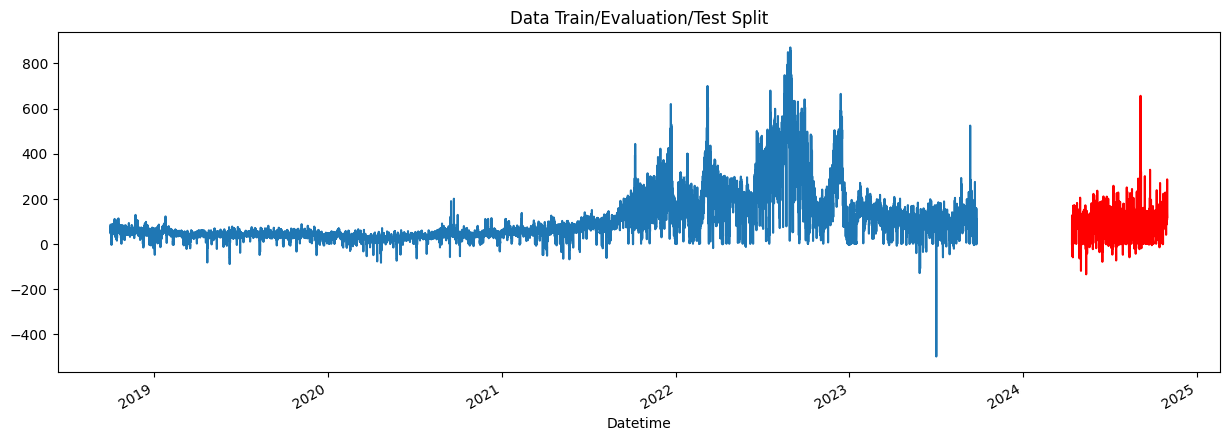

In [128]:
fig, ax = plt.subplots(figsize=(15, 5))
train["Price"].plot(ax=ax, label='Training Set', title='Data Train/Evaluation/Test Split')
test["Price"].plot(ax=ax, label='Test Set', color="red")
eval["Price"].plot(ax=ax, label='Evaluation Set', color="cian")
ax.axvline(SPLIT_DATE_EVAL, color='green', ls='--')
ax.axvline(SPLIT_DATE_TEST, color='orange', ls='--')
ax.legend(['Training Set', 'Test Set', 'Evaluation Set'])
plt.show()

In [ ]:
def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['dayofyear'] = df.index.dayofyear
    df['weekofyear'] = df.index.isocalendar().week

    for window in [3, 6, 12]: # hours
        df[f'ma_{int(window)}_hours'] = df['Price'].rolling(window=window).mean()
        df[f'biomass_ma_{int(window)}_hours'] = df['Biomass'].rolling(window=window).mean()
        df[f'pumped_storage_generation_ma_{int(window)}_hours'] = df['Pumped storage generation'].rolling(window=window).mean()
        df[f'hard_coal_ma_{int(window)}_hours'] = df['Hard Coal'].rolling(window=window).mean()
    
    for window in [24, 72, 168]:  # 1 day 3 days, and 1 week
        df[f'ma_{int(window / 24)}_days'] = df['Price'].rolling(window=window).mean()
        df[f'biomass_ma_{int(window / 24)}_days'] = df['Biomass'].rolling(window=window).mean()
        df[f'pumped_storage_generation_ma_{int(window / 24)}_days'] = df['Pumped storage generation'].rolling(window=window).mean()
        df[f'hard_coal_ma_{int(window / 24)}_days'] = df['Hard Coal'].rolling(window=window).mean()

    return df

### Feature Selection

In [ ]:
train = create_features(train)
test = create_features(test)
eval = create_features(eval)

FEATURES = [
    "hour",
    "dayofyear",
    "dayofweek",
    "ma_3_hours",
    "ma_6_hours",
    "ma_1_days",
    "ma_3_days",
    "ma_7_days",
    "Biomass",
    "biomass_ma_3_hours",
    "biomass_ma_6_hours",
    "biomass_ma_1_days",
    "biomass_ma_3_days",
    "biomass_ma_7_days",
    "pumped_storage_generation_ma_3_hours",
    "pumped_storage_generation_ma_6_hours",
    "pumped_storage_generation_ma_1_days",
    "pumped_storage_generation_ma_3_days",
    "pumped_storage_generation_ma_7_days",
    "Hard Coal",
    "hard_coal_ma_3_hours",
    "hard_coal_ma_6_hours",
    "hard_coal_ma_1_days",
    "hard_coal_ma_3_days",
    "hard_coal_ma_7_days",
    "Hydro",
    "Lignite",
    "Natural Gas",
    "Nuclear",
    "Other",
    "Pumped storage generation",
    "Solar",
    "Wind offshore",
    "Wind onshore",
    # "temperature_2m",
    # "temperature_2m_previous_day1",
    # "temperature_2m_previous_day2",
    # "temperature_2m_previous_day3",
    # "temperature_2m_previous_day4",
    # "temperature_2m_previous_day5",
    # "temperature_2m_previous_day6",
    # "temperature_2m_previous_day7",
    # "relative_humidity_2m",
    # "relative_humidity_2m_previous_day1",
    # "relative_humidity_2m_previous_day2",
    # "relative_humidity_2m_previous_day3",
    # "relative_humidity_2m_previous_day4",
    # "relative_humidity_2m_previous_day5",
    # "relative_humidity_2m_previous_day6",
    # "relative_humidity_2m_previous_day7",
    # "precipitation",
    # "precipitation_previous_day1",
    # "precipitation_previous_day2",
    # "precipitation_previous_day3",
    # "precipitation_previous_day4",
    # "precipitation_previous_day5",
    # "precipitation_previous_day6",
    # "precipitation_previous_day7",
    # "surface_pressure",
    # "surface_pressure_previous_day1",
    # "surface_pressure_previous_day2",
    # "surface_pressure_previous_day3",
    # "surface_pressure_previous_day4",
    # "surface_pressure_previous_day5",
    # "surface_pressure_previous_day7",
    # "shortwave_radiation",
    # "shortwave_radiation_previous_day1",
    # "shortwave_radiation_previous_day2",
    # "shortwave_radiation_previous_day3",
    # "shortwave_radiation_previous_day4",
    # "shortwave_radiation_previous_day5",
    # "shortwave_radiation_previous_day6",
    # "shortwave_radiation_previous_day7",
    # "wind_speed_80m",
    # "wind_speed_80m_previous_day1",
    # "wind_speed_80m_previous_day2",
    # "wind_speed_80m_previous_day3",
    # "wind_speed_80m_previous_day4",
    # "wind_speed_80m_previous_day5",
    # "wind_speed_80m_previous_day6",
    # "wind_speed_80m_previous_day7",
]

TARGET = "Price"

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

X_val = eval[FEATURES]
y_val = eval[TARGET]

### Auto ML

In [ ]:
def objective(params):

    params['max_depth'] = int(params['max_depth'])
    params['n_estimators'] = int(params['n_estimators'])
    params['min_child_weight'] = int(params['min_child_weight'])
    params['max_delta_step'] = int(params['max_delta_step'])
    params['early_stopping_rounds'] = int(params['early_stopping_rounds'])

    model = xgb.XGBRegressor(
        early_stopping_rounds=params['early_stopping_rounds'],
        max_depth=params['max_depth'],
        learning_rate=params['learning_rate'],
        n_estimators=params['n_estimators'],
        gamma=params['gamma'],
        min_child_weight=params['min_child_weight'],
        subsample=params['subsample'],
        colsample_bytree=params['colsample_bytree'],
        colsample_bynode=params['colsample_bynode'],
        colsample_bylevel=params['colsample_bylevel'],
        max_delta_step=params['max_delta_step'],
        reg_lambda=params['reg_lambda'],
        eval_metric='rmse',
        objective='reg:squarederror',
    )
    
    # Fit the model on the training data
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],  # Provide validation set for early stopping
        verbose=False  # Suppress training output
    )
    
    # Predict on the validation set
    predictions = model.predict(X_test)
    
    # Calculate the root mean squared error (RMSE)
    rmse = root_mean_squared_error(y_test, predictions)
    
    return rmse

In [ ]:
search = False

search_space = {
    "early_stopping_rounds": hp.choice("early_stopping_rounds", np.arange(3, 300, 1, dtype=int)),
    "max_depth": hp.choice("max_depth", np.arange(30, 300, 1, dtype=int)),
    "learning_rate": hp.uniform("learning_rate", 0.01, 0.5),
    "gamma": hp.uniform("gamma", 0, 1),
    "reg_lambda": hp.uniform("reg_lambda", 0.7, 0.9),
    "colsample_bytree": hp.uniform("colsample_bytree", 0.5, 1),
    "colsample_bynode": hp.uniform("colsample_bynode", 0.5, 1),
    "colsample_bylevel": hp.uniform("colsample_bylevel", 0.5, 1),
    "n_estimators": hp.choice("n_estimators", np.arange(100, 1000, 10, dtype="int")),
    "min_child_weight": hp.choice("min_child_weight", np.arange(1, 10, 1, dtype="int")),
    "max_delta_step": hp.choice("max_delta_step", np.arange(1, 10, 1, dtype="int")),
    "subsample": hp.uniform("subsample", 0.5, 1),
}

# Keeping track of the optimization history
trials = Trials()

if search:

    # Run the Hyperopt optimization
    best = fmin(
        fn=objective,  # Objective function
        space=search_space,  # Hyperparameter space
        algo=tpe.suggest,  # Optimization algorithm
        max_evals=50,  # Number of trials
        trials=trials,  # Store trials history
    )

    #Display best parameters
    print(f"early_stopping_rounds: {best["early_stopping_rounds"]}, default: 10\nmax_depth: {best["max_depth"]}, default: 6\nlearning_rate: {best["learning_rate"]}, default: 0.3\nn_estimators: {best["n_estimators"]}, default: 100\ngamma: {best["gamma"]}, default: 0\nmin_child_weight: {best["min_child_weight"]}, default: 1\nsubsample: {best["subsample"]}, default: 1\ncolsample_bytree: {best["colsample_bytree"]}, default: 1\ncolsample_bynode: {best["colsample_bynode"]}, default: 1\ncolsample_bylevel: {best["colsample_bylevel"]}, default: 1\nmax_delta_step: {best["max_delta_step"]}, default: 0\nreg_lambda: {best["reg_lambda"]}, default: 1\n")

100%|██████████| 50/50 [07:08<00:00,  8.57s/trial, best loss: 13.931287381798029]
early_stopping_rounds: 296, default: 10
max_depth: 265, default: 6
learning_rate: 0.06353100803653348, default: 0.3
n_estimators: 46, default: 100
gamma: 0.5377048949263098, default: 0
min_child_weight: 7, default: 1
subsample: 0.570177180656792, default: 1
colsample_bytree: 0.962822244227529, default: 1
colsample_bynode: 0.9957326809295394, default: 1
colsample_bylevel: 0.5162484309158684, default: 1
max_delta_step: 4, default: 0
reg_lambda: 0.8110680642468295, default: 1



In [ ]:
    # Train the final model with the best hyperparameters on the full dataset
    final_model = xgb.XGBRegressor(
            early_stopping_rounds=best['early_stopping_rounds'],
            max_depth=best['max_depth'],
            learning_rate=best['learning_rate'],
            n_estimators=best['n_estimators'],
            gamma=best['gamma'],
            min_child_weight=best['min_child_weight'],
            subsample=best['subsample'],
            colsample_bytree=best['colsample_bytree'],
            colsample_bynode=best['colsample_bynode'],
            colsample_bylevel=best['colsample_bylevel'],
            max_delta_step=best['max_delta_step'],
            reg_lambda=best['reg_lambda'],
            # reg_alpha=best['reg_alpha'],
            eval_metric='rmse',
            objective='reg:squarederror',
    )

    final_model.fit(X_train, y_train,  eval_set=[(X_val, y_val)])

    # Predict on the test set or validation set
    final_predictions = final_model.predict(X_test)
    final_rmse = root_mean_squared_error(y_test, final_predictions)
    print("\n--- Final model RMSE:", final_rmse, "---")

[0]	validation_0-rmse:45.92894
[1]	validation_0-rmse:45.74708
[2]	validation_0-rmse:45.55279
[3]	validation_0-rmse:45.35951
[4]	validation_0-rmse:45.18467
[5]	validation_0-rmse:44.99228
[6]	validation_0-rmse:44.80520
[7]	validation_0-rmse:44.61376
[8]	validation_0-rmse:44.42820
[9]	validation_0-rmse:44.23743
[10]	validation_0-rmse:44.04823
[11]	validation_0-rmse:43.86905
[12]	validation_0-rmse:43.67943
[13]	validation_0-rmse:43.49164
[14]	validation_0-rmse:43.30353
[15]	validation_0-rmse:43.11725
[16]	validation_0-rmse:42.93087
[17]	validation_0-rmse:42.74452
[18]	validation_0-rmse:42.55899
[19]	validation_0-rmse:42.37370
[20]	validation_0-rmse:42.18931
[21]	validation_0-rmse:42.00479
[22]	validation_0-rmse:41.82192
[23]	validation_0-rmse:41.64385
[24]	validation_0-rmse:41.46070
[25]	validation_0-rmse:41.27835
[26]	validation_0-rmse:41.09733
[27]	validation_0-rmse:40.91557
[28]	validation_0-rmse:40.74314
[29]	validation_0-rmse:40.56383
[30]	validation_0-rmse:40.38843
[31]	validation_0-

## Final Model

In [ ]:
upfate = False

best_params = {
    "base_score": np.float64(0.3888133835396405),
    "colsample_bytree": np.float64(0.6349243426308729),
    "early_stopping_rounds": np.int64(4),
    "gamma": np.float64(0.2753854688925828),
    "learning_rate": np.float64(0.05),
    "max_depth": np.int64(50),
    "min_child_weight": np.int64(7),
    "n_estimators": np.int64(200),
    "subsample": np.float64(0.5719023844219375),
}

if update:
    best_params = {
        "early_stopping_rounds": best['early_stopping_rounds'],
        "max_depth": best['max_depth'],
        "learning_rate": best['learning_rate'],
        "n_estimators": best['n_estimators'],
        "gamma": best['gamma'],
        "min_child_weight": best['min_child_weight'],
        "subsample": best['subsample'],
        "colsample_bytree": best['colsample_bytree'],
        "colsample_bynode": best['colsample_bynode'],
        "colsample_bylevel": best['colsample_bylevel'],
        "max_delta_step": best['max_delta_step'],
        "reg_lambda": best['reg_lambda'],
    }

print(
    f"early_stopping_rounds: {best_params["early_stopping_rounds"]}, default: 10\nmax_depth: {best_params["max_depth"]}, default: 6\nlearning_rate: {best_params["learning_rate"]}, default: 0:3\nn_estimators: {best_params["n_estimators"]}, default: 100\ngamma: {best_params["gamma"]}, default: 0\nmin_child_weight: {best_params["min_child_weight"]}, default: 1\nsubsample: {best_params["subsample"]}, default: 1\ncolsample_bytree: {best_params["colsample_bytree"]}, default: 1\ncolsample_bynode: {best_params["colsample_bynode"]}, default: 1\ncolsample_bylevel: {best_params["colsample_bylevel"]}, default: 1\nmax_delta_step: {best_params["max_delta_step"]}, default: 0\nreg_lambda: {best_params["reg_lambda"]}, default: 1\n"
)

# print(dict(best_params))

reg = xgb.XGBRegressor(**best_params)

reg.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=25)

early_stopping_rounds: 296, default: 10
max_depth: 265, default: 6
learning_rate: 0.06353100803653348, default: 0:3
n_estimators: 46, default: 100
gamma: 0.5377048949263098, default: 0
min_child_weight: 7, default: 1
subsample: 0.570177180656792, default: 1
colsample_bytree: 0.962822244227529, default: 1
colsample_bynode: 0.9957326809295394, default: 1
colsample_bylevel: 0.5162484309158684, default: 1
max_delta_step: 4, default: 0
reg_lambda: 0.8110680642468295, default: 1



[0]	validation_0-rmse:45.92894
[25]	validation_0-rmse:41.27835
[45]	validation_0-rmse:37.77827


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=np.float64(0.5162484309158684),
             colsample_bynode=np.float64(0.9957326809295394),
             colsample_bytree=np.float64(0.962822244227529), device=None,
             early_stopping_rounds=np.int64(296), enable_categorical=False,
             eval_metric=None, feature_types=None,
             gamma=np.float64(0.5377048949263098), gro...
             importance_type=None, interaction_constraints=None,
             learning_rate=np.float64(0.06353100803653348), max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=np.int64(4), max_depth=np.int64(265),
             max_leaves=None, min_child_weight=np.int64(7), missing=nan,
             monotone_constraints=None, multi_strategy=None,
             n_estimators=np.int64(46), n_jobs=None, num_parallel_tree=None,
             random_state=None, ...)

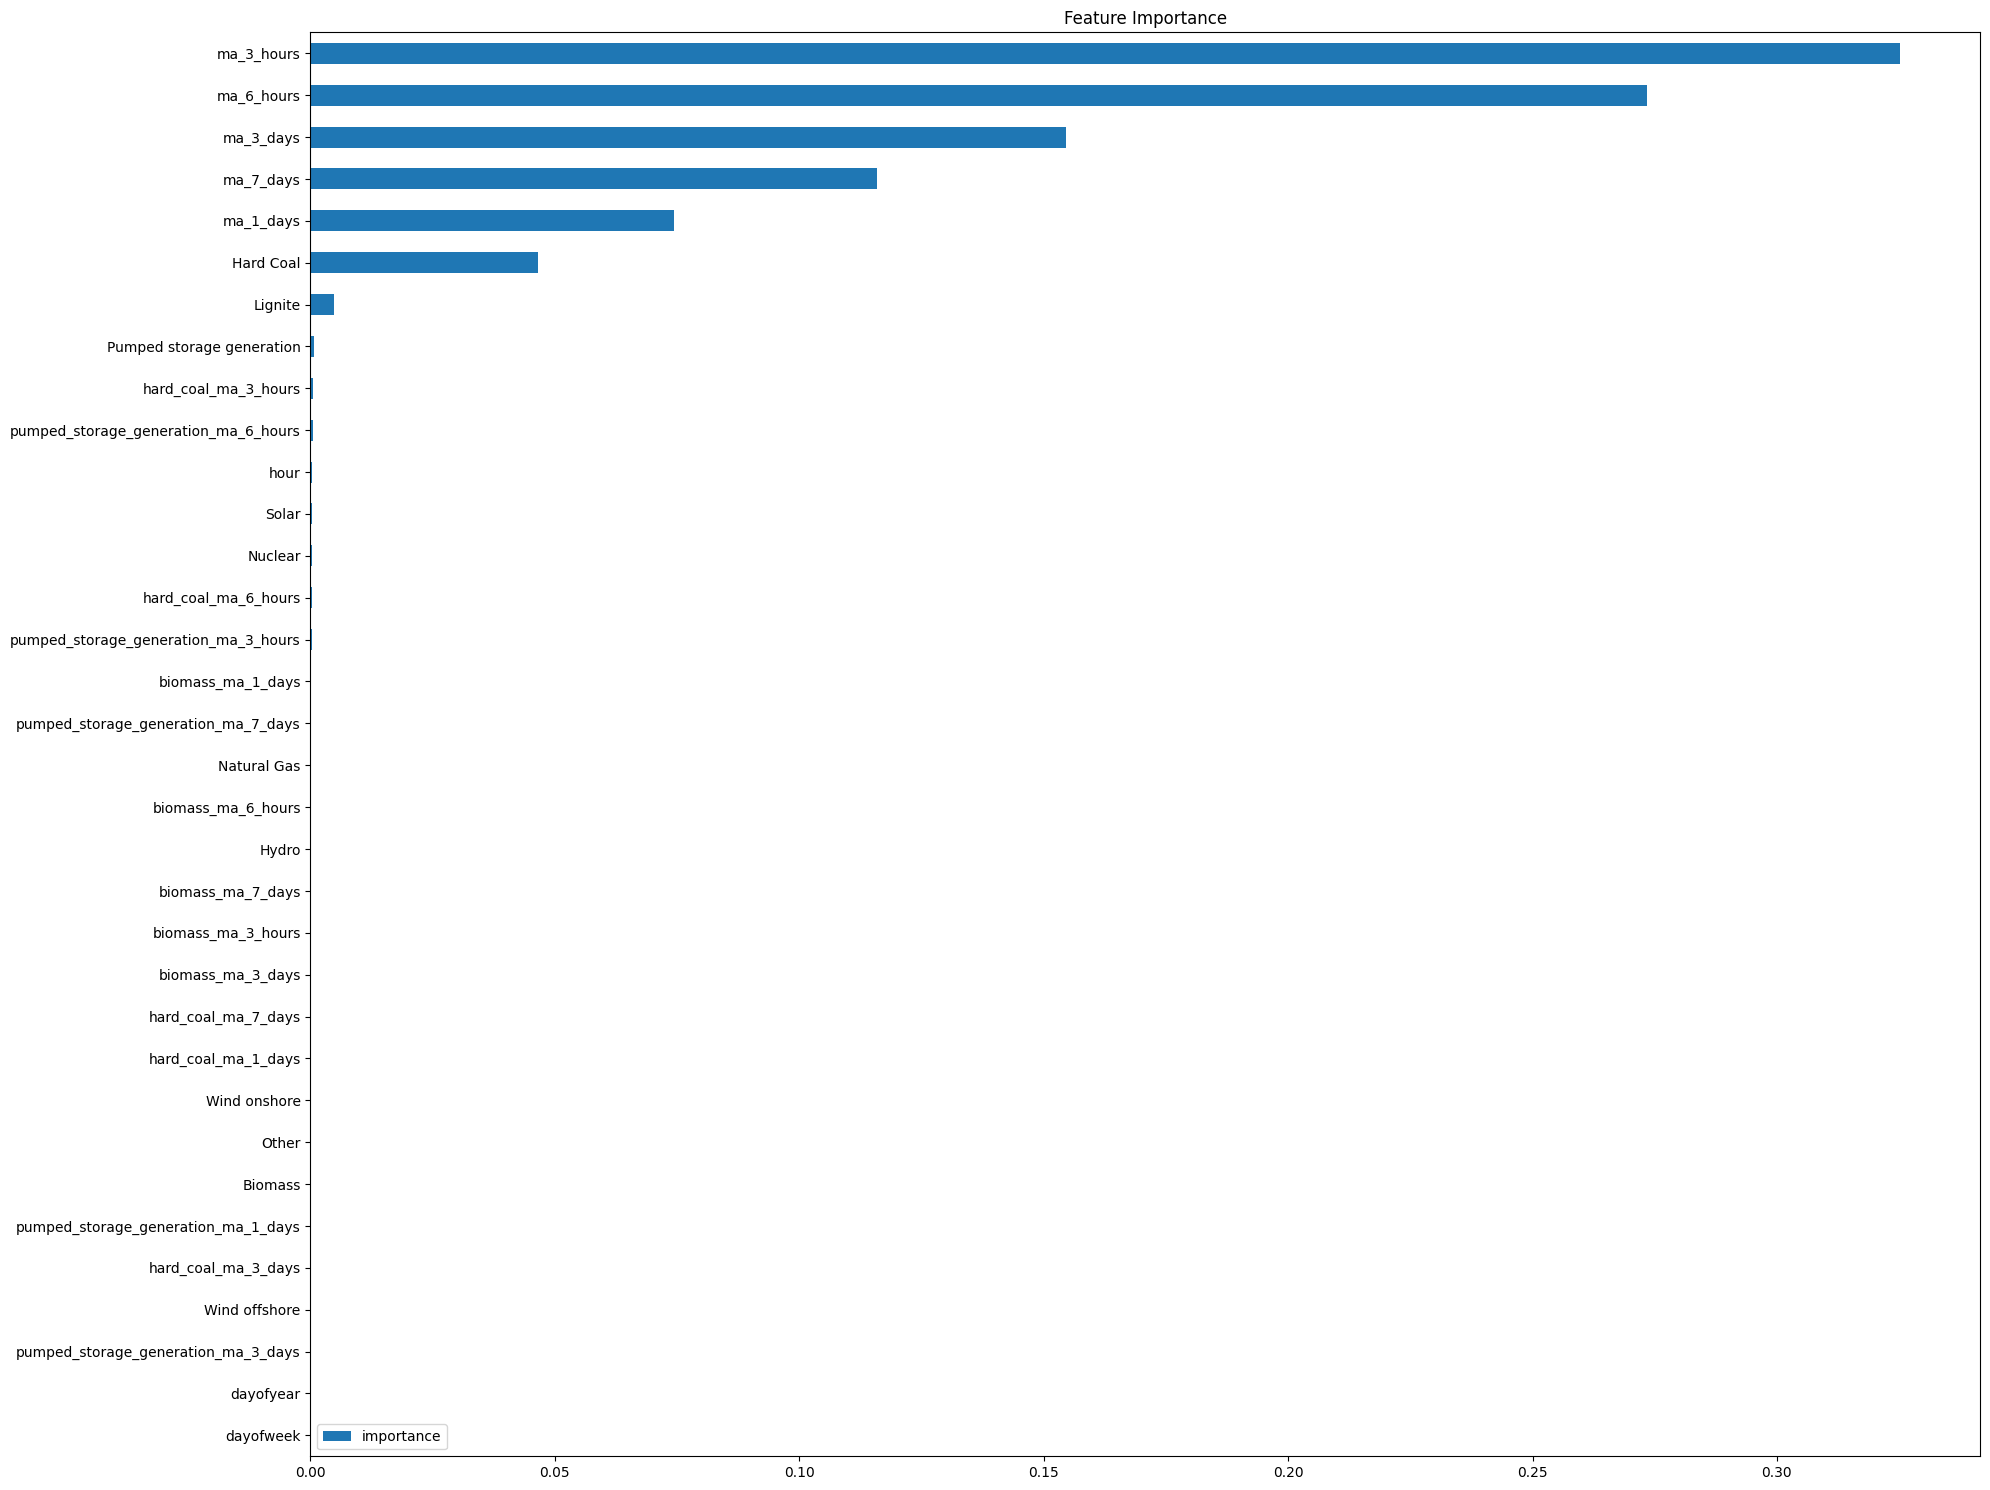

In [ ]:
# plt.figure(figsize=(30, 20))
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'], )
fi.sort_values('importance').plot(kind='barh', title='Feature Importance', figsize=(20, 15))
plt.tight_layout()
buf = io.BytesIO()
plt.savefig(buf, format='png')
plt.show()
plt.close()
buf.seek(0)

feature_importance_image = Image.open(buf)

In [ ]:
test['prediction'] = reg.predict(X_test)
prediction_df = merged_df.merge(test[['prediction']], how='left', left_index=True, right_index=True)

In [ ]:
#test error fot the entire test set
score = root_mean_squared_error(test[TARGET], test['prediction'])
print(f'RMSE Score on Test set: {score:.2f}')

RMSE Score on Test set: 45.59


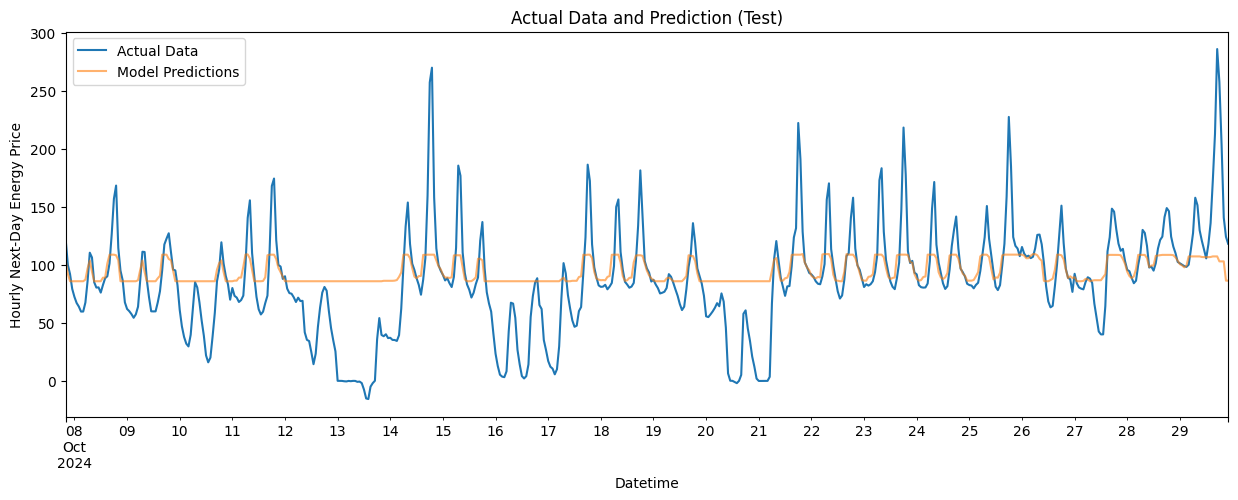

In [ ]:

WINDOW = prediction_df.iloc[:int(0.01 * (len(prediction_df)))].copy()

ax = WINDOW[[TARGET]].plot(figsize=(15, 5))
prediction_df['prediction'].plot(ax=ax, style='-', alpha=0.6)
ax.set_xlim(WINDOW.index.min(), WINDOW.index.max())
ax.set_ylabel("Hourly Next-Day Energy Price")
plt.legend(['Actual Data', 'Model Predictions'])    
ax.set_title('Actual Data and Prediction (Test)')

buf = io.BytesIO()
plt.savefig(buf, format='png')
plt.show()
plt.close()
buf.seek(0)

ts_image = Image.open(buf)

### Average absolute error by day

In [ ]:
test['error'] = np.abs(test[TARGET] - prediction_df['prediction'])
test['date'] = test.index.date
test['error'].groupby(test['date']).mean()

date
2024-04-12    26.171965
2024-04-13    71.971837
2024-04-14    74.845281
2024-04-15    29.859421
2024-04-16    35.900850
                ...    
2024-10-25    19.040820
2024-10-26    11.213186
2024-10-27    16.418698
2024-10-28    11.175472
2024-10-29    40.349348
Name: error, Length: 201, dtype: float64

### Specific Date Predictions

In [ ]:
date = '2024-10-29'
predictions = prediction_df.loc[date, 'prediction']

# Display the result
print(predictions)

Datetime
2024-10-29 22:00:00     86.299675
2024-10-29 21:00:00     86.299675
2024-10-29 20:00:00    102.900223
2024-10-29 19:00:00    102.900223
2024-10-29 18:00:00    102.900223
2024-10-29 17:00:00    107.173393
2024-10-29 16:00:00    107.173393
2024-10-29 15:00:00    107.173393
2024-10-29 14:00:00    106.665138
2024-10-29 13:00:00    106.551193
2024-10-29 12:00:00    106.551193
2024-10-29 11:00:00    106.551193
2024-10-29 10:00:00    106.665138
2024-10-29 09:00:00    107.173393
2024-10-29 08:00:00    107.173393
2024-10-29 07:00:00    107.173393
2024-10-29 06:00:00    107.173393
2024-10-29 05:00:00    107.173393
2024-10-29 04:00:00    107.173393
2024-10-29 03:00:00     99.197990
2024-10-29 02:00:00     97.756454
2024-10-29 01:00:00     99.450005
2024-10-29 00:00:00    100.461281
Name: prediction, dtype: float32


In [129]:
ts = datetime.now().strftime("%Y%m%d_%H%M%S")
output_dir = f'./pickle/model_{score: .4g}_rmse_{ts}'
os.makedirs(output_dir, exist_ok=True)

model_dump_path = os.path.join(output_dir, "model.pickle")
with open(model_dump_path, "wb") as file:
    pickle.dump(reg, file)
hp_path = os.path.join(output_dir, "hyperparams.json")
with open(hp_path, "w") as file:
    best_params_native = {k: (int(v) if isinstance(v, (np.integer, int)) else float(v) if isinstance(v, (np.floating, float)) else v) for k, v in best_params.items()}
    json.dump(best_params_native, file, indent=4)
output_filename = 'plot_image.png'
ts_chart_path = os.path.join(output_dir, output_filename)
ts_image.save(ts_chart_path)

output_filename = 'feature_importance.png'
fi_path = os.path.join(output_dir, output_filename)
feature_importance_image.save(fi_path)

save models pickel
add 500 to axis -> z-standardisation might also work
features?
register

